In [1]:
import torchvision.transforms
from torch.utils.data import DataLoader
import torch.utils.data.dataloader
from torch import nn
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchvision.datasets import ImageFolder
import torchsummary
import util as utl
import os
import cv2

In [2]:
tns = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

ds_path = os.path.join(os.getcwd(), 'data', 'dataset', 'MNIST_1')
ds = utl.MNIST_DS(ds_path)

In [3]:
LEN_DS = len(ds)
N_TRAIN = int(0.1 * LEN_DS)
N_VALID = int(0.1 * LEN_DS)
N_TEST = LEN_DS - N_TRAIN - N_VALID
train_ds, valid_ds, test_ds = \
    torch.utils.data.random_split(
        ds, [N_TRAIN, N_VALID, N_TEST])

train_dl = DataLoader(dataset=train_ds, batch_size=16, shuffle=True)
valid_dl = DataLoader(dataset=valid_ds, batch_size=16, shuffle=True)
test_dl = DataLoader(dataset=test_ds, batch_size=512, shuffle=True)

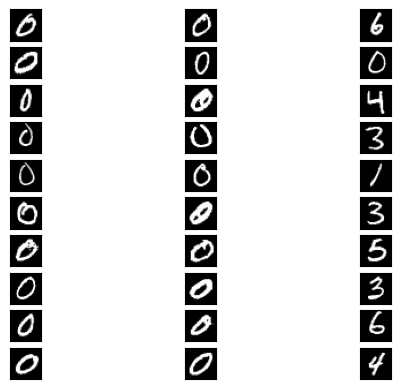

In [4]:
fig = plt.figure()

for i in range(10):
    triplet = ds[i]
    q = triplet[0][0]
    p = triplet[1][0]
    n = triplet[2][0]

    plt.subplot(10, 3, i*3+1)
    plt.imshow(p, cmap='gray')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(10, 3, i*3+2)
    plt.imshow(q, cmap='gray')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(10, 3, i*3+3)
    plt.imshow(n, cmap='gray')
    plt.xticks([])
    plt.yticks([])

In [5]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3,3)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2), stride=2),
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2), stride=2),
    nn.Flatten(),
    nn.Linear(800, 10),
    nn.Sigmoid(),
    nn.Linear(10, 10))#,
    #nn.LogSoftmax())
s = torchsummary.summary(model)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            160
├─ReLU: 1-2                              --
├─MaxPool2d: 1-3                         --
├─Conv2d: 1-4                            4,640
├─ReLU: 1-5                              --
├─MaxPool2d: 1-6                         --
├─Flatten: 1-7                           --
├─Linear: 1-8                            8,010
├─Sigmoid: 1-9                           --
├─Linear: 1-10                           110
Total params: 12,920
Trainable params: 12,920
Non-trainable params: 0


In [ ]:
trn_ls, vld_ls, bst_state = utl.train_triplet(
    mdl=model,
    train_dataloader=train_dl,
    valid_dataloader=valid_dl,
    n_epoch=10,
    opt=torch.optim.Adam(params=model.parameters(), lr=0.01),
    criterion=nn.TripletMarginLoss(),
    valid_step=1,
    save_path='')

Epoch1: 100%|██████████| 375/375 [01:17<00:00,  4.81it/s]


In [ ]:
plt.plot(trn_ls)
plt.plot(vld_ls)
plt.legend(['train loss', 'validation loss'])
plt.title('training procedure')
plt.show()

Drawing some samples of the trained model
title of each sample is its predicted value
The title color indicated true or false predication(green or red)

In [ ]:
model.state_dict(bst_state)
model.eval()
ROWS = 10
COLS = 10
en = enumerate(test_dl)
_, (inps, outs) = next(en)
with torch.inference_mode():
    preds = model(inps)

fig = plt.figure()
#fig.text('Predicted samples')
for i in range(ROWS*COLS):
    plt.subplot(ROWS, COLS, i+1)
    im = inps[i][0]
    plt.imshow(im, cmap='gray')
    p = torch.argmax(preds[i]).item()
    o = outs[i].item()
    color = 'g'
    if p!=o:
        color = 'r'
    plt.title(str(p), color=color)
    plt.subplots_adjust(top=2)
    plt.xticks([])
    plt.yticks([])
fig.show()

Drawing confusion matrix

In [ ]:
sum = 0.0

preds = []
labels = []
for idx, (inps, outs) in enumerate(test_dl):
    p = model(inps)
    p = torch.argmax(p, 1)
    preds.extend(p.tolist())
    labels.extend(outs.tolist())

cm = confusion_matrix(labels, preds)
ConfusionMatrixDisplay(cm).plot(cmap='gray')

calculating accuracy

In [ ]:
for i in range(len(labels)):
    if labels[i] == preds[i]:
        sum+=1

print('accuracy: ' +
    str(sum/len(test_ds)))